## Dataset Info.

### train.csv [파일]
PRODUCT_ID : 제품의 고유 ID  
Y_Class : 제품 품질 상태(Target)   
0 : 적정 기준 미달 (부적합)  
1 : 적합  
2 : 적정 기준 초과 (부적합)  
Y_Quality : 제품 품질 관련 정량적 수치  
TIMESTAMP : 제품이 공정에 들어간 시각  
LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)  
PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)  
X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수  


### test.csv [파일]
PRODUCT_ID : 제품의 고유 ID  
TIMESTAMP : 제품이 공정에 들어간 시각  
LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)  
PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)  
X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수  


### sample_submission.csv [파일] - 제출 양식
PRODUCT_ID : 제품의 고유 ID  
Y_Class : 예측한 제품 품질 상태  
0 : 적정 기준 미달 (부적합)  
1 : 적합  
2 : 적정 기준 초과 (부적합)  

실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)  
'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.  

# Import

In [31]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [32]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

# Data Load

In [33]:
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

FileNotFoundError: [Errno 2] No such file or directory: './dataset/train.csv'

In [ ]:
train_df.columns

In [ ]:
# 결측치 파악

train_df.isnull().sum()

In [ ]:
train = train_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Quality'])
train = train.fillna(0)

test = test_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP'])
test = test.fillna(0)

In [ ]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    
    for label in np.unique(test[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i]) 
print('Done.')

In [ ]:
train

In [ ]:
test

In [ ]:
train_data = train.iloc[:,1:]
train_data = train_data.to_numpy()

train_label = train['Y_Class']
train_label = train_label.to_numpy()

In [ ]:
train_data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size = 0.2, random_state=0)

In [ ]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(y_train, num_classes=3)
one_hot_val_labels = to_categorical(y_val, num_classes=3)

In [34]:
X_train.shape

(478, 2877)

In [61]:
from keras import models, layers, metrics
import tensorflow as tf
model = models.Sequential()
model.add(layers.Dense(32, activation='relu')) # input_shape은 지정하지 않아도 자동으로 선택
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# 다중 분류를 활용해야함. 일반적인 categorical은 one-hot-vector 형식을 받는다고 하네요.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [62]:
history = model.fit(X_train, y_train, epochs=100, batch_size = 32, validation_data=(X_val, y_val)) # 배치 사이즈는 작을수록 유리해요.
# flat minimum이라고 해서 학습에 시간이 더 걸리지만, test set과의 오차를 줄이는데 유리

Epoch 1/100
15/15 [==============================] - 0s 8ms/step - loss: 29866006528.0000 - sparse_categorical_accuracy: 0.5439 - val_loss: 14115778560.0000 - val_sparse_categorical_accuracy: 0.7000
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 7737291264.0000 - sparse_categorical_accuracy: 0.5774 - val_loss: 5737332736.0000 - val_sparse_categorical_accuracy: 0.5750
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 6202596864.0000 - sparse_categorical_accuracy: 0.5816 - val_loss: 6328950784.0000 - val_sparse_categorical_accuracy: 0.6750
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 3946024448.0000 - sparse_categorical_accuracy: 0.6151 - val_loss: 8788384768.0000 - val_sparse_categorical_accuracy: 0.4417
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 4378396160.0000 - sparse_categorical_accuracy: 0.5858 - val_loss: 3111947008.0000 - val_sparse_categorical_accuracy: 0.6833
Epoch 6/100
1

15/15 [==============================] - 0s 2ms/step - loss: 1861834752.0000 - sparse_categorical_accuracy: 0.6318 - val_loss: 1295919232.0000 - val_sparse_categorical_accuracy: 0.6250
Epoch 43/100
15/15 [==============================] - 0s 2ms/step - loss: 1982479488.0000 - sparse_categorical_accuracy: 0.6004 - val_loss: 1152233600.0000 - val_sparse_categorical_accuracy: 0.6250
Epoch 44/100
15/15 [==============================] - 0s 2ms/step - loss: 1589886208.0000 - sparse_categorical_accuracy: 0.6046 - val_loss: 2545023744.0000 - val_sparse_categorical_accuracy: 0.5917
Epoch 45/100
15/15 [==============================] - 0s 2ms/step - loss: 2343209216.0000 - sparse_categorical_accuracy: 0.6046 - val_loss: 3354547968.0000 - val_sparse_categorical_accuracy: 0.5833
Epoch 46/100
15/15 [==============================] - 0s 2ms/step - loss: 2163398400.0000 - sparse_categorical_accuracy: 0.5816 - val_loss: 4680363520.0000 - val_sparse_categorical_accuracy: 0.5500
Epoch 47/100
15/15 [===

15/15 [==============================] - 0s 2ms/step - loss: 708468864.0000 - sparse_categorical_accuracy: 0.6046 - val_loss: 543046784.0000 - val_sparse_categorical_accuracy: 0.5667
Epoch 84/100
15/15 [==============================] - 0s 2ms/step - loss: 1126884352.0000 - sparse_categorical_accuracy: 0.5983 - val_loss: 844862528.0000 - val_sparse_categorical_accuracy: 0.5750
Epoch 85/100
15/15 [==============================] - 0s 2ms/step - loss: 1360381952.0000 - sparse_categorical_accuracy: 0.6234 - val_loss: 1747308160.0000 - val_sparse_categorical_accuracy: 0.5083
Epoch 86/100
15/15 [==============================] - 0s 2ms/step - loss: 1491845888.0000 - sparse_categorical_accuracy: 0.6172 - val_loss: 1744387584.0000 - val_sparse_categorical_accuracy: 0.5917
Epoch 87/100
15/15 [==============================] - 0s 2ms/step - loss: 2966601216.0000 - sparse_categorical_accuracy: 0.6130 - val_loss: 1914067072.0000 - val_sparse_categorical_accuracy: 0.5083
Epoch 88/100
15/15 [======

In [63]:
history_dic = history.history
history_dic.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [64]:
new_keys = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
history_dic = dict((new_key, val) for new_key, val in zip(new_keys, history_dic.values()))
history_dic.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
history_dic.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

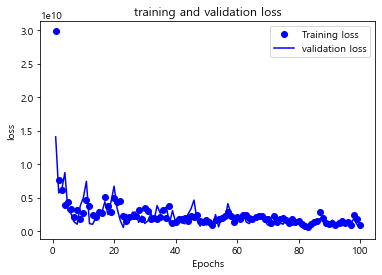

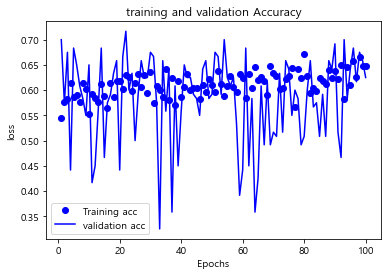

In [66]:
import matplotlib.pyplot as plt
loss = history_dic['loss']
val_loss = history_dic['val_loss']
plt.clf()

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()
acc= history_dic['accuracy']
val_acc = history_dic['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [67]:
predictions = model.predict(test)

10/10 [==============================] - 0s 889us/step


In [68]:
tmp = []
for p in predictions:
    tmp.append(list(p).index(max(p)))
from collections import Counter
Counter(tmp)

Counter({1: 26, 0: 111, 2: 173})

In [69]:
test

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,5,2,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,2,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,5,2,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,4,2,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,5,2,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,5,2,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
